# Dimensionality Reduction: Mental Health in Tech 2016

## 1. Load Data & Scaling

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

RUN = 'run_03'

df = pd.read_csv(f'../../data/{RUN}/processed/mental_health_preprocessed.csv')
print(f"Shape: {df.shape}")

# Store column names for interpretation
feature_names = df.columns.tolist()

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

Shape: (1143, 91)


## 2. PCA with Axis Interpretation (NEW in run_03)

Components for 80% variance: 37
Components for 95% variance: 57


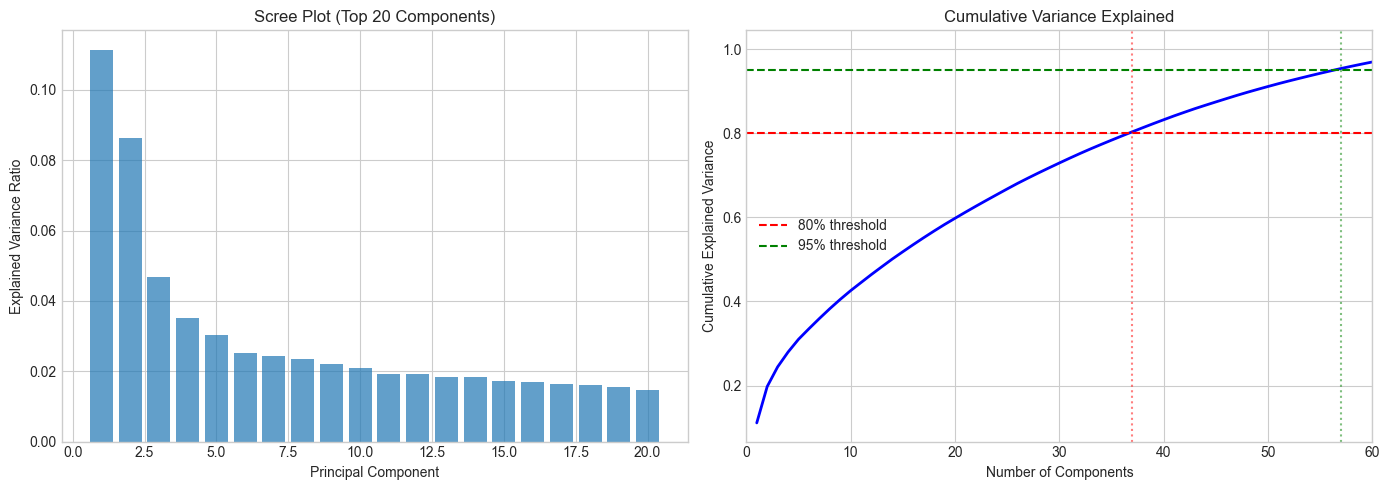

In [ ]:
from sklearn.decomposition import PCA

pca_full = PCA()
pca_full.fit(X_scaled)

exp_var = pca_full.explained_variance_ratio_
cum_var = np.cumsum(exp_var)

n_80 = np.argmax(cum_var >= 0.80) + 1
n_95 = np.argmax(cum_var >= 0.95) + 1

print(f"Components for 80% variance: {n_80}")
print(f"Components for 95% variance: {n_95}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, 21), exp_var[:20], alpha=0.7, label='Individual')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot (Top 20 Components)')

axes[1].plot(range(1, len(cum_var)+1), cum_var, 'b-', linewidth=2)
axes[1].axhline(y=0.80, color='r', linestyle='--', label='80% threshold')
axes[1].axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
axes[1].axvline(x=n_80, color='r', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_95, color='g', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].set_xlim(0, 60)

plt.tight_layout()
os.makedirs(f'../../plots/{RUN}', exist_ok=True)
plt.savefig(f'../../plots/{RUN}/pca_variance_explained.png', dpi=150)
plt.show()

In [15]:
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)

loadings = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_names
)

print("\nTop POSITIVE loadings (high values on PC1):")
for feat, val in loadings['PC1'].nlargest(8).items():
    print(f"  {val:+.3f}: {feat[:60]}")

print("\nTop NEGATIVE loadings (low values on PC1):")
for feat, val in loadings['PC1'].nsmallest(8).items():
    print(f"  {val:+.3f}: {feat[:60]}")


Top POSITIVE loadings (high values on PC1):
  +0.289: idx_mental_health_burden
  +0.248: If you have a mental health issue, do you feel that it inter
  +0.246: Have you had a mental health disorder in the past?_Yes
  +0.245: Do you currently have a mental health disorder?_Yes
  +0.234: Have you ever sought treatment for a mental health issue fro
  +0.218: diagnosed_pro_mood_related
  +0.216: diagnosed_yes_mood_related
  +0.201: diagnosed_yes_anxiety_related

Top NEGATIVE loadings (low values on PC1):
  -0.256: Have you been diagnosed with a mental health condition by a 
  -0.219: Have you had a mental health disorder in the past?_No
  -0.219: Do you currently have a mental health disorder?_No
  -0.153: Do you have a family history of mental illness?_No
  -0.118: Have you observed or experienced an unsupportive or badly ha
  -0.099: Have your observations of how another individual who discuss
  -0.088: Do you think that discussing a mental health disorder with y
  -0.080: Would you bri

In [20]:
# PCA preprocessing for downstream methods
pca_preprocessing = PCA(n_components=50)
X_pca_50 = pca_preprocessing.fit_transform(X_scaled)

## 3. MDS (Multidimensional Scaling)

In [21]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42, n_jobs=-1, n_init=4, normalized_stress='auto')
X_mds = mds.fit_transform(X_pca_50)
print(f"MDS Stress: {mds.stress_:.4f}")

MDS Stress: 12683979.2754


## 4. LLE (Locally Linear Embedding)

In [22]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=15, random_state=42, n_jobs=-1)
X_lle = lle.fit_transform(X_pca_50)
print(f"LLE Reconstruction Error: {lle.reconstruction_error_:.6f}")

LLE Reconstruction Error: 0.006874


## 5. t-SNE

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_pca_50)
print(f"t-SNE KL Divergence: {tsne.kl_divergence_:.2f}")

t-SNE KL Divergence: 1.66


## 6. UMAP

In [24]:
import umap

reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_pca_50)
print("UMAP completed")

UMAP completed


## 7. Method Comparison

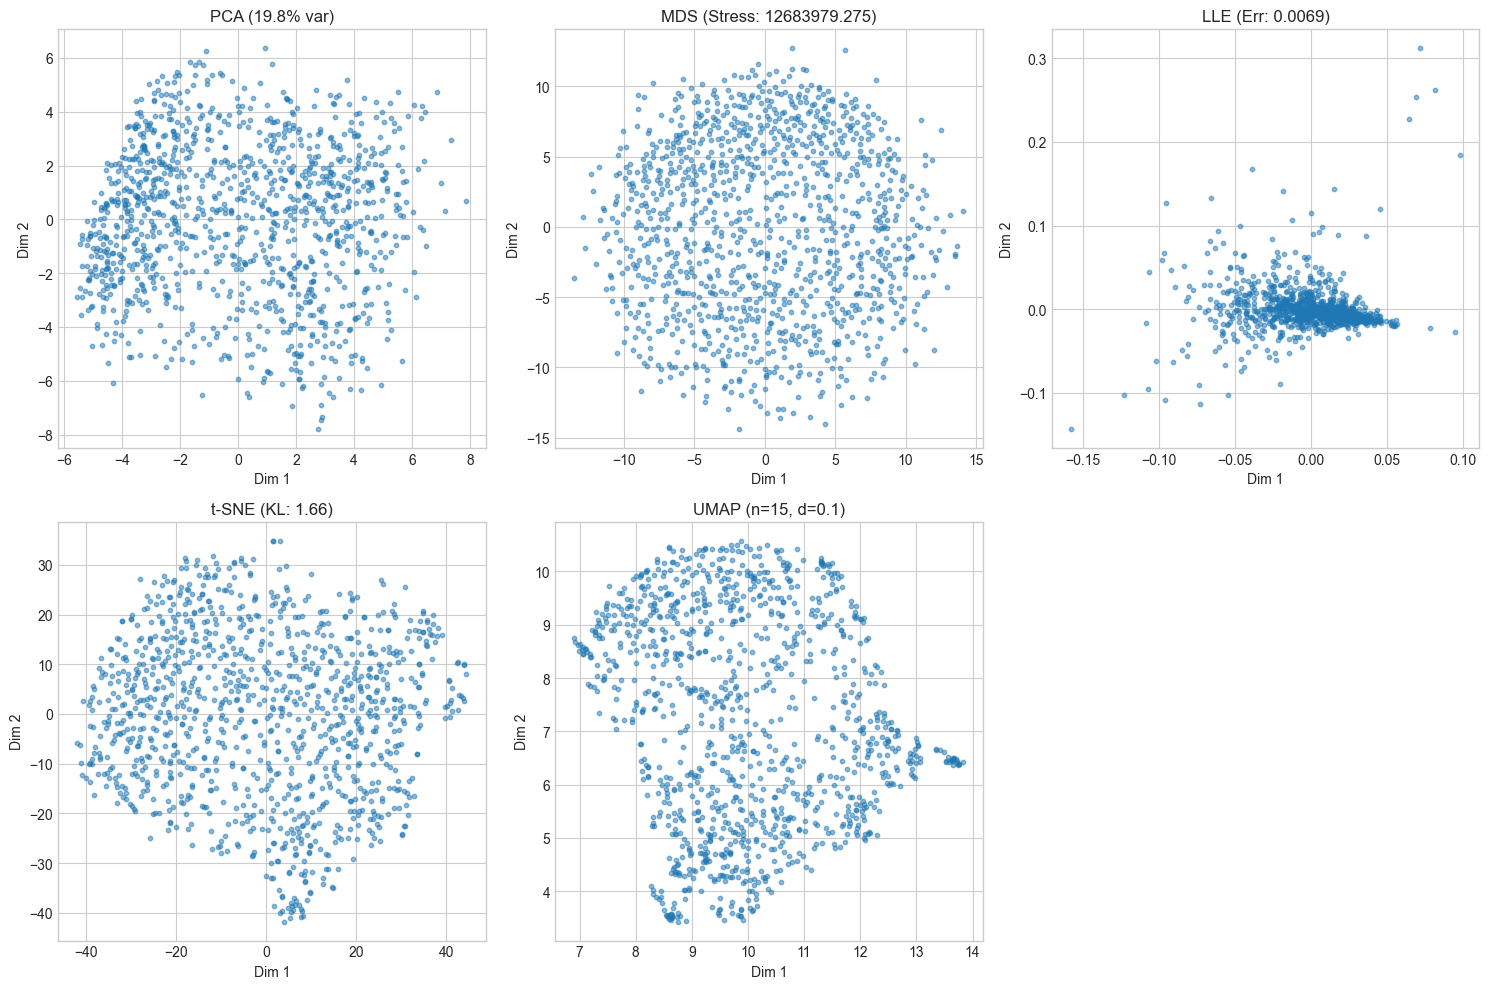

In [29]:
# Grid comparison of all methods
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

methods_data = [
    ('PCA', X_pca, f'{pca_2d.explained_variance_ratio_.sum():.1%} var'),
    ('MDS', X_mds, f'Stress: {mds.stress_:.3f}'),
    ('LLE', X_lle, f'Err: {lle.reconstruction_error_:.4f}'),
    ('t-SNE', X_tsne, f'KL: {tsne.kl_divergence_:.2f}'),
    ('UMAP', X_umap, 'n=15, d=0.1')
]

for idx, (name, data, metric) in enumerate(methods_data):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    ax.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10)
    ax.set_title(f'{name} ({metric})')
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')

# Summary in last subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig(f'../../plots/{RUN}/dimensionality_reduction_comparison.png', dpi=150)
plt.show()

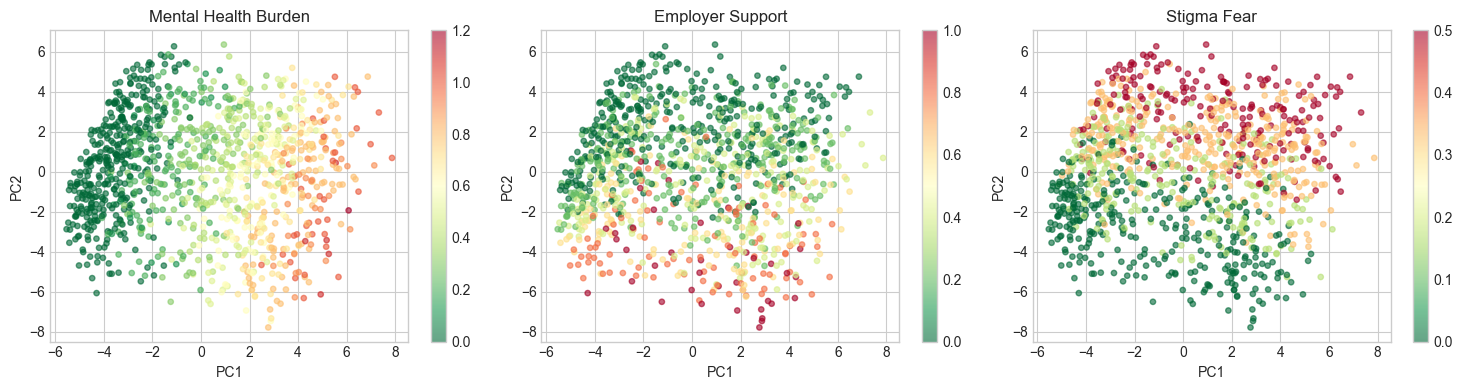

In [ ]:
idx_cols = [col for col in feature_names if col.startswith('idx_')]

if idx_cols:
    fig, axes = plt.subplots(1, len(idx_cols), figsize=(5*len(idx_cols), 4))
    if len(idx_cols) == 1:
        axes = [axes]
    
    for idx, col in enumerate(idx_cols):
        sc = axes[idx].scatter(X_pca[:, 0], X_pca[:, 1], 
                               c=df[col], cmap='RdYlGn_r', alpha=0.6, s=15)
        axes[idx].set_xlabel('PC1')
        axes[idx].set_ylabel('PC2')
        axes[idx].set_title(col.replace('idx_', '').replace('_', ' ').title())
        plt.colorbar(sc, ax=axes[idx])
    
    plt.tight_layout()
    plt.savefig(f'../../plots/{RUN}/pca_composite_indices.png', dpi=150)
    plt.show()

## 8. Save Reduced Data

In [ ]:
output_dir = f'../../data/{RUN}/reduced'
os.makedirs(output_dir, exist_ok=True)

reduced_data = {
    'pca': X_pca,
    'mds': X_mds,
    'lle': X_lle,
    'tsne': X_tsne,
    'umap': X_umap
}

for name, data in reduced_data.items():
    df_reduced = pd.DataFrame(data, columns=['dim1', 'dim2'])
    df_reduced.to_csv(f'{output_dir}/{name}_2d.csv', index=False)

loadings.to_csv(f'{output_dir}/pca_loadings.csv')

Saved 5 reduced datasets to ../../data/run_03/reduced
Also saved PCA loadings for interpretation
